In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchsampler import ImbalancedDatasetSampler

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [65]:
wine_path = './winequality-white.csv'
wine_df = pd.read_csv(wine_path, delimiter=';')
wine_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


<AxesSubplot:xlabel='quality', ylabel='count'>

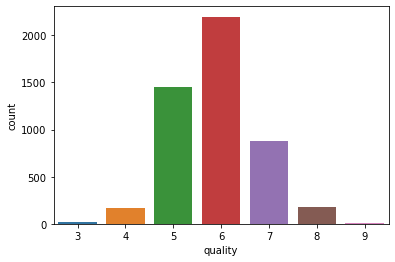

In [66]:
sns.countplot(x = 'quality', data=wine_df)

In [67]:
# Multiclass classification의 target은 [0, n]
# 현재 데이터셋의 target 범위는 [3, 9]
# target 범위 [0, 6]으로 조정하기
class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5,
    9:6
}

idx2class = {v:k for k, v in class2idx.items()}

wine_df['quality'].replace(class2idx, inplace=True)

In [68]:
# 마지막 컬럼은 target
X = wine_df.iloc[:, 0:-1]
y = wine_df.iloc[:, -1]

In [69]:
# train, val, test 분리
# 6:2:2
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.25, random_state=42)

In [70]:
# input 정규화
scaler = StandardScaler()
X_train_scaled = torch.tensor(scaler.fit_transform(X_train))
X_val_scaled = torch.tensor(scaler.transform(X_val))
X_test_scaled = torch.tensor(scaler.transform(X_test))

In [71]:
y_train = torch.tensor(np.array(y_train))
y_val = torch.tensor(np.array(y_val))
y_test = torch.tensor(np.array(y_test))

In [72]:
# target의 class별 데이터분포 계산
def get_class_distribution(obj):
    count_dict = {
        '3': 0,
        '4': 0,
        '5': 0,
        '6': 0,
        '7': 0,
        '8': 0,
        '9': 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['3'] += 1
        elif i == 1: 
            count_dict['4'] += 1
        elif i == 2: 
            count_dict['5'] += 1
        elif i == 3: 
            count_dict['6'] += 1
        elif i == 4: 
            count_dict['7'] += 1  
        elif i == 5: 
            count_dict['8'] += 1              
        elif i == 6: 
            count_dict['9'] += 1              
        else:
            print('oops...')
            
    return count_dict

In [73]:
# pytorch Dataset 만들기
class CustomDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
train_dataset = CustomDataset(X_train_scaled.float(), y_train.long())
val_dataset = CustomDataset(X_val_scaled.float(), y_val.long())
test_dataset = CustomDataset(X_test_scaled.float(), y_test.long())

In [74]:
# 오버샘플링에 사용할 sampler 만들기
# val, test는 모델 평가용 set이므로 오버샘플링 안해도 됨
target_list = torch.tensor([target for target in train_dataset.y_data])

In [75]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1.0 / torch.tensor(class_count, dtype=torch.float)
class_weights_all = class_weights[target_list]

In [76]:
# WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True)

In [77]:
# 모델 하이퍼파라미터
EPOCHS = 4000
BATCH_SIZE = 512
LEARNING_RATE = 0.0017

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 7

In [78]:
# pytorch DataLoader
# 오버샘플링 한 train_loader
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
# 오버샘플링 안한 train_loader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [79]:
# pytorch model
class MulticlassClassification(nn.Module):
    def __init__(self, num_features, num_classes):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_classes) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.4)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        
        x = self.layer_out(x)
        
        return x

In [80]:
# nvidia cuda 사용
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [81]:
# 모델 생성
model = MulticlassClassification(num_features=NUM_FEATURES, num_classes=NUM_CLASSES)

model.to(device)

# multiclass classification loss
# softmax 포함됨
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
# optimizer adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# learning rate decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

In [82]:
# 예측 정확도 계산 함수
def multi_accuracy(y_pred, y_target):
    y_pred_softmax = torch.log_softmax(y_pred, dim=1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=1)
    
    correct_pred = (y_pred_tags == y_target).float()
    accuracy = correct_pred.sum() / len(correct_pred)
    
    accuracy *= 100.0
    
    return accuracy

In [83]:
for epoch in tqdm(range(1, EPOCHS + 1)):
    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_accuracy = multi_accuracy(y_train_pred, y_train_batch)
        
        for param in model.parameters():
            param.grad = None
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_accuracy += train_accuracy.item()
        
        
    scheduler.step()
        
    with torch.no_grad():
        val_epoch_loss = 0.0
        val_epoch_accuracy = 0.0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_accuracy = multi_accuracy(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_accuracy += val_accuracy.item()
            
    mean_train_accuracy = train_epoch_accuracy / len(train_loader)
    mean_val_accuracy = val_epoch_accuracy / len(val_loader)
    mean_train_loss = train_epoch_loss / len(train_loader)
    mean_val_loss = val_epoch_loss / len(val_loader)
    
    print(f'Epoch {epoch+0:04}: | Train Loss: {mean_train_loss:.4f} | Val Loss: {mean_val_loss:.4f} | Train Acc: {mean_train_accuracy:.2f}| Val Acc: {mean_val_accuracy:.2f}')

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 0001: | Train Loss: 1.9974 | Val Loss: 1.8482 | Train Acc: 29.93| Val Acc: 30.10
Epoch 0002: | Train Loss: 1.7016 | Val Loss: 1.6958 | Train Acc: 29.65| Val Acc: 26.07
Epoch 0003: | Train Loss: 1.5320 | Val Loss: 1.5631 | Train Acc: 30.19| Val Acc: 25.92
Epoch 0004: | Train Loss: 1.4475 | Val Loss: 1.4730 | Train Acc: 30.70| Val Acc: 26.06
Epoch 0005: | Train Loss: 1.3791 | Val Loss: 1.4080 | Train Acc: 31.18| Val Acc: 28.94
Epoch 0006: | Train Loss: 1.2997 | Val Loss: 1.3689 | Train Acc: 32.58| Val Acc: 31.42
Epoch 0007: | Train Loss: 1.2754 | Val Loss: 1.3621 | Train Acc: 34.90| Val Acc: 34.59
Epoch 0008: | Train Loss: 1.1988 | Val Loss: 1.3732 | Train Acc: 36.54| Val Acc: 35.72
Epoch 0009: | Train Loss: 1.1899 | Val Loss: 1.3930 | Train Acc: 38.08| Val Acc: 37.54
Epoch 0010: | Train Loss: 1.1212 | Val Loss: 1.3635 | Train Acc: 37.27| Val Acc: 37.54
Epoch 0011: | Train Loss: 1.0850 | Val Loss: 1.3541 | Train Acc: 39.05| Val Acc: 38.88
Epoch 0012: | Train Loss: 1.0638 | Val Loss

Epoch 0097: | Train Loss: 0.4153 | Val Loss: 2.3544 | Train Acc: 63.00| Val Acc: 50.02
Epoch 0098: | Train Loss: 0.4072 | Val Loss: 2.3642 | Train Acc: 64.14| Val Acc: 50.36
Epoch 0099: | Train Loss: 0.4285 | Val Loss: 2.6146 | Train Acc: 63.14| Val Acc: 51.41
Epoch 0100: | Train Loss: 0.3930 | Val Loss: 2.6551 | Train Acc: 63.86| Val Acc: 50.92
Epoch 0101: | Train Loss: 0.4034 | Val Loss: 2.5296 | Train Acc: 63.98| Val Acc: 48.87
Epoch 0102: | Train Loss: 0.4093 | Val Loss: 2.2078 | Train Acc: 64.57| Val Acc: 47.62
Epoch 0103: | Train Loss: 0.4070 | Val Loss: 2.1796 | Train Acc: 63.80| Val Acc: 49.84
Epoch 0104: | Train Loss: 0.4135 | Val Loss: 2.1007 | Train Acc: 63.39| Val Acc: 50.01
Epoch 0105: | Train Loss: 0.4098 | Val Loss: 2.4756 | Train Acc: 62.68| Val Acc: 50.73
Epoch 0106: | Train Loss: 0.4025 | Val Loss: 2.7242 | Train Acc: 63.38| Val Acc: 50.42
Epoch 0107: | Train Loss: 0.3988 | Val Loss: 2.6887 | Train Acc: 63.59| Val Acc: 49.30
Epoch 0108: | Train Loss: 0.3921 | Val Loss

Epoch 0193: | Train Loss: 0.2585 | Val Loss: 2.6599 | Train Acc: 74.89| Val Acc: 54.86
Epoch 0194: | Train Loss: 0.2633 | Val Loss: 2.7438 | Train Acc: 74.86| Val Acc: 55.36
Epoch 0195: | Train Loss: 0.2547 | Val Loss: 2.8930 | Train Acc: 75.83| Val Acc: 56.05
Epoch 0196: | Train Loss: 0.2572 | Val Loss: 2.9361 | Train Acc: 75.01| Val Acc: 56.44
Epoch 0197: | Train Loss: 0.2549 | Val Loss: 2.8091 | Train Acc: 75.64| Val Acc: 55.64
Epoch 0198: | Train Loss: 0.2567 | Val Loss: 2.7092 | Train Acc: 74.79| Val Acc: 54.17
Epoch 0199: | Train Loss: 0.2521 | Val Loss: 2.7575 | Train Acc: 75.93| Val Acc: 55.48
Epoch 0200: | Train Loss: 0.2442 | Val Loss: 2.7911 | Train Acc: 76.30| Val Acc: 56.92
Epoch 0201: | Train Loss: 0.2510 | Val Loss: 2.8942 | Train Acc: 76.34| Val Acc: 56.96
Epoch 0202: | Train Loss: 0.2462 | Val Loss: 2.9851 | Train Acc: 76.47| Val Acc: 56.34
Epoch 0203: | Train Loss: 0.2500 | Val Loss: 2.8775 | Train Acc: 75.28| Val Acc: 57.22
Epoch 0204: | Train Loss: 0.2582 | Val Loss

Epoch 0289: | Train Loss: 0.1616 | Val Loss: 3.3229 | Train Acc: 83.88| Val Acc: 59.36
Epoch 0290: | Train Loss: 0.1783 | Val Loss: 3.2226 | Train Acc: 83.54| Val Acc: 59.20
Epoch 0291: | Train Loss: 0.1675 | Val Loss: 2.9973 | Train Acc: 83.78| Val Acc: 58.38
Epoch 0292: | Train Loss: 0.1612 | Val Loss: 2.8846 | Train Acc: 83.87| Val Acc: 58.63
Epoch 0293: | Train Loss: 0.1792 | Val Loss: 2.9182 | Train Acc: 83.55| Val Acc: 57.98
Epoch 0294: | Train Loss: 0.1717 | Val Loss: 2.9840 | Train Acc: 83.76| Val Acc: 59.23
Epoch 0295: | Train Loss: 0.1719 | Val Loss: 3.0107 | Train Acc: 83.16| Val Acc: 60.02
Epoch 0296: | Train Loss: 0.1774 | Val Loss: 3.2769 | Train Acc: 82.56| Val Acc: 58.80
Epoch 0297: | Train Loss: 0.1652 | Val Loss: 3.4644 | Train Acc: 83.75| Val Acc: 58.38
Epoch 0298: | Train Loss: 0.1707 | Val Loss: 3.4155 | Train Acc: 84.44| Val Acc: 59.15
Epoch 0299: | Train Loss: 0.1715 | Val Loss: 3.3598 | Train Acc: 84.18| Val Acc: 58.70
Epoch 0300: | Train Loss: 0.1659 | Val Loss

Epoch 0385: | Train Loss: 0.1201 | Val Loss: 4.7216 | Train Acc: 88.45| Val Acc: 61.04
Epoch 0386: | Train Loss: 0.1159 | Val Loss: 4.6609 | Train Acc: 89.70| Val Acc: 62.20
Epoch 0387: | Train Loss: 0.1219 | Val Loss: 4.3713 | Train Acc: 88.79| Val Acc: 61.41
Epoch 0388: | Train Loss: 0.1093 | Val Loss: 4.4122 | Train Acc: 88.82| Val Acc: 61.32
Epoch 0389: | Train Loss: 0.1198 | Val Loss: 4.3723 | Train Acc: 89.46| Val Acc: 60.61
Epoch 0390: | Train Loss: 0.1219 | Val Loss: 4.2020 | Train Acc: 88.80| Val Acc: 60.59
Epoch 0391: | Train Loss: 0.1159 | Val Loss: 4.2119 | Train Acc: 88.45| Val Acc: 60.38
Epoch 0392: | Train Loss: 0.1127 | Val Loss: 4.3571 | Train Acc: 88.82| Val Acc: 59.93
Epoch 0393: | Train Loss: 0.1089 | Val Loss: 4.3766 | Train Acc: 90.20| Val Acc: 60.38
Epoch 0394: | Train Loss: 0.1017 | Val Loss: 4.2271 | Train Acc: 90.62| Val Acc: 60.31
Epoch 0395: | Train Loss: 0.1016 | Val Loss: 4.2794 | Train Acc: 90.09| Val Acc: 61.16
Epoch 0396: | Train Loss: 0.1037 | Val Loss

Epoch 0480: | Train Loss: 0.1191 | Val Loss: 4.1461 | Train Acc: 90.70| Val Acc: 60.75
Epoch 0481: | Train Loss: 0.1625 | Val Loss: 4.8689 | Train Acc: 88.88| Val Acc: 60.50
Epoch 0482: | Train Loss: 0.2196 | Val Loss: 4.7077 | Train Acc: 87.25| Val Acc: 59.47
Epoch 0483: | Train Loss: 0.1990 | Val Loss: 4.1390 | Train Acc: 86.57| Val Acc: 59.53
Epoch 0484: | Train Loss: 0.1793 | Val Loss: 4.0007 | Train Acc: 85.14| Val Acc: 58.70
Epoch 0485: | Train Loss: 0.1809 | Val Loss: 4.1761 | Train Acc: 85.90| Val Acc: 56.78
Epoch 0486: | Train Loss: 0.1718 | Val Loss: 4.5216 | Train Acc: 84.91| Val Acc: 60.14
Epoch 0487: | Train Loss: 0.1778 | Val Loss: 4.1809 | Train Acc: 86.52| Val Acc: 59.48
Epoch 0488: | Train Loss: 0.2054 | Val Loss: 4.2850 | Train Acc: 87.03| Val Acc: 60.76
Epoch 0489: | Train Loss: 0.2281 | Val Loss: 4.3677 | Train Acc: 85.57| Val Acc: 60.19
Epoch 0490: | Train Loss: 0.2218 | Val Loss: 3.8604 | Train Acc: 85.39| Val Acc: 57.65
Epoch 0491: | Train Loss: 0.2460 | Val Loss

Epoch 0576: | Train Loss: 0.0565 | Val Loss: 4.8652 | Train Acc: 95.03| Val Acc: 61.68
Epoch 0577: | Train Loss: 0.0606 | Val Loss: 4.8807 | Train Acc: 94.53| Val Acc: 61.90
Epoch 0578: | Train Loss: 0.0612 | Val Loss: 4.6482 | Train Acc: 95.64| Val Acc: 61.72
Epoch 0579: | Train Loss: 0.0558 | Val Loss: 4.6109 | Train Acc: 94.55| Val Acc: 62.11
Epoch 0580: | Train Loss: 0.0555 | Val Loss: 4.7712 | Train Acc: 95.23| Val Acc: 61.69
Epoch 0581: | Train Loss: 0.0637 | Val Loss: 4.8903 | Train Acc: 95.03| Val Acc: 61.32
Epoch 0582: | Train Loss: 0.0686 | Val Loss: 4.9249 | Train Acc: 93.86| Val Acc: 61.84
Epoch 0583: | Train Loss: 0.0671 | Val Loss: 4.9791 | Train Acc: 94.04| Val Acc: 61.81
Epoch 0584: | Train Loss: 0.0695 | Val Loss: 5.0476 | Train Acc: 94.08| Val Acc: 61.76
Epoch 0585: | Train Loss: 0.0661 | Val Loss: 5.0317 | Train Acc: 93.94| Val Acc: 61.96
Epoch 0586: | Train Loss: 0.0648 | Val Loss: 4.9846 | Train Acc: 94.57| Val Acc: 61.30
Epoch 0587: | Train Loss: 0.0603 | Val Loss

Epoch 0672: | Train Loss: 0.0421 | Val Loss: 5.3179 | Train Acc: 96.87| Val Acc: 61.51
Epoch 0673: | Train Loss: 0.0409 | Val Loss: 5.3596 | Train Acc: 96.48| Val Acc: 60.77
Epoch 0674: | Train Loss: 0.0416 | Val Loss: 5.3266 | Train Acc: 96.48| Val Acc: 61.76
Epoch 0675: | Train Loss: 0.0424 | Val Loss: 5.4779 | Train Acc: 95.90| Val Acc: 61.32
Epoch 0676: | Train Loss: 0.0425 | Val Loss: 5.4637 | Train Acc: 95.99| Val Acc: 61.75
Epoch 0677: | Train Loss: 0.0388 | Val Loss: 5.3628 | Train Acc: 96.36| Val Acc: 61.99
Epoch 0678: | Train Loss: 0.0397 | Val Loss: 5.3374 | Train Acc: 96.74| Val Acc: 62.18
Epoch 0679: | Train Loss: 0.0343 | Val Loss: 5.3562 | Train Acc: 96.96| Val Acc: 62.07
Epoch 0680: | Train Loss: 0.0466 | Val Loss: 5.4479 | Train Acc: 96.10| Val Acc: 62.26
Epoch 0681: | Train Loss: 0.0447 | Val Loss: 5.3079 | Train Acc: 96.53| Val Acc: 62.77
Epoch 0682: | Train Loss: 0.0485 | Val Loss: 5.4287 | Train Acc: 96.08| Val Acc: 63.50
Epoch 0683: | Train Loss: 0.0437 | Val Loss

Epoch 0767: | Train Loss: 0.1860 | Val Loss: 4.7011 | Train Acc: 86.90| Val Acc: 59.87
Epoch 0768: | Train Loss: 0.1447 | Val Loss: 4.5796 | Train Acc: 87.86| Val Acc: 59.61
Epoch 0769: | Train Loss: 0.1379 | Val Loss: 4.2826 | Train Acc: 89.35| Val Acc: 59.87
Epoch 0770: | Train Loss: 0.1512 | Val Loss: 4.2547 | Train Acc: 88.94| Val Acc: 60.17
Epoch 0771: | Train Loss: 0.1225 | Val Loss: 4.4756 | Train Acc: 89.29| Val Acc: 61.62
Epoch 0772: | Train Loss: 0.1043 | Val Loss: 4.8106 | Train Acc: 91.30| Val Acc: 61.50
Epoch 0773: | Train Loss: 0.0958 | Val Loss: 4.9909 | Train Acc: 91.58| Val Acc: 61.08
Epoch 0774: | Train Loss: 0.0883 | Val Loss: 4.9771 | Train Acc: 92.35| Val Acc: 61.35
Epoch 0775: | Train Loss: 0.0749 | Val Loss: 4.9738 | Train Acc: 93.37| Val Acc: 61.68
Epoch 0776: | Train Loss: 0.0793 | Val Loss: 5.0892 | Train Acc: 93.48| Val Acc: 61.18
Epoch 0777: | Train Loss: 0.0846 | Val Loss: 5.1503 | Train Acc: 93.48| Val Acc: 61.02
Epoch 0778: | Train Loss: 0.0803 | Val Loss

Epoch 0863: | Train Loss: 0.0741 | Val Loss: 5.1202 | Train Acc: 94.12| Val Acc: 61.45
Epoch 0864: | Train Loss: 0.0724 | Val Loss: 5.3723 | Train Acc: 93.87| Val Acc: 61.56
Epoch 0865: | Train Loss: 0.0765 | Val Loss: 5.3076 | Train Acc: 94.53| Val Acc: 60.83
Epoch 0866: | Train Loss: 0.0660 | Val Loss: 5.2676 | Train Acc: 93.99| Val Acc: 62.09
Epoch 0867: | Train Loss: 0.0609 | Val Loss: 5.1611 | Train Acc: 94.01| Val Acc: 62.39
Epoch 0868: | Train Loss: 0.0518 | Val Loss: 5.1967 | Train Acc: 95.52| Val Acc: 62.00
Epoch 0869: | Train Loss: 0.0525 | Val Loss: 5.1814 | Train Acc: 95.69| Val Acc: 61.89
Epoch 0870: | Train Loss: 0.0522 | Val Loss: 5.2100 | Train Acc: 95.42| Val Acc: 62.57
Epoch 0871: | Train Loss: 0.0449 | Val Loss: 5.3046 | Train Acc: 96.28| Val Acc: 61.76
Epoch 0872: | Train Loss: 0.0439 | Val Loss: 5.3881 | Train Acc: 96.32| Val Acc: 61.94
Epoch 0873: | Train Loss: 0.0497 | Val Loss: 5.4015 | Train Acc: 95.89| Val Acc: 60.94
Epoch 0874: | Train Loss: 0.0496 | Val Loss

Epoch 0959: | Train Loss: 0.0279 | Val Loss: 5.9404 | Train Acc: 97.73| Val Acc: 61.60
Epoch 0960: | Train Loss: 0.0272 | Val Loss: 5.9627 | Train Acc: 97.90| Val Acc: 61.70
Epoch 0961: | Train Loss: 0.0245 | Val Loss: 6.0996 | Train Acc: 97.77| Val Acc: 61.71
Epoch 0962: | Train Loss: 0.0264 | Val Loss: 6.1552 | Train Acc: 97.71| Val Acc: 61.79
Epoch 0963: | Train Loss: 0.0327 | Val Loss: 6.0837 | Train Acc: 97.37| Val Acc: 61.67
Epoch 0964: | Train Loss: 0.0290 | Val Loss: 6.0522 | Train Acc: 98.02| Val Acc: 62.16
Epoch 0965: | Train Loss: 0.0282 | Val Loss: 6.1495 | Train Acc: 97.83| Val Acc: 61.38
Epoch 0966: | Train Loss: 0.0279 | Val Loss: 6.1732 | Train Acc: 97.16| Val Acc: 60.87
Epoch 0967: | Train Loss: 0.0287 | Val Loss: 6.2300 | Train Acc: 97.88| Val Acc: 61.48
Epoch 0968: | Train Loss: 0.0295 | Val Loss: 6.1523 | Train Acc: 97.81| Val Acc: 61.19
Epoch 0969: | Train Loss: 0.0247 | Val Loss: 6.0978 | Train Acc: 98.21| Val Acc: 60.76
Epoch 0970: | Train Loss: 0.0264 | Val Loss

Epoch 1055: | Train Loss: 0.0207 | Val Loss: 6.2481 | Train Acc: 98.22| Val Acc: 62.47
Epoch 1056: | Train Loss: 0.0222 | Val Loss: 6.3439 | Train Acc: 97.90| Val Acc: 62.26
Epoch 1057: | Train Loss: 0.0221 | Val Loss: 6.3226 | Train Acc: 98.10| Val Acc: 62.36
Epoch 1058: | Train Loss: 0.0207 | Val Loss: 6.2432 | Train Acc: 97.86| Val Acc: 62.06
Epoch 1059: | Train Loss: 0.0218 | Val Loss: 6.2291 | Train Acc: 98.04| Val Acc: 61.86
Epoch 1060: | Train Loss: 0.0218 | Val Loss: 6.3307 | Train Acc: 98.40| Val Acc: 62.58
Epoch 1061: | Train Loss: 0.0256 | Val Loss: 6.3082 | Train Acc: 97.65| Val Acc: 62.19
Epoch 1062: | Train Loss: 0.0222 | Val Loss: 6.2985 | Train Acc: 98.00| Val Acc: 62.22
Epoch 1063: | Train Loss: 0.0204 | Val Loss: 6.3545 | Train Acc: 98.12| Val Acc: 63.12
Epoch 1064: | Train Loss: 0.0202 | Val Loss: 6.3529 | Train Acc: 98.40| Val Acc: 63.09
Epoch 1065: | Train Loss: 0.0195 | Val Loss: 6.3519 | Train Acc: 98.58| Val Acc: 62.17
Epoch 1066: | Train Loss: 0.0184 | Val Loss

Epoch 1150: | Train Loss: 0.0210 | Val Loss: 6.7450 | Train Acc: 98.16| Val Acc: 62.18
Epoch 1151: | Train Loss: 0.0225 | Val Loss: 6.6884 | Train Acc: 97.91| Val Acc: 61.59
Epoch 1152: | Train Loss: 0.0192 | Val Loss: 6.7713 | Train Acc: 98.08| Val Acc: 62.00
Epoch 1153: | Train Loss: 0.0220 | Val Loss: 6.8155 | Train Acc: 98.11| Val Acc: 61.76
Epoch 1154: | Train Loss: 0.0225 | Val Loss: 6.6281 | Train Acc: 98.41| Val Acc: 61.56
Epoch 1155: | Train Loss: 0.0307 | Val Loss: 6.4707 | Train Acc: 97.42| Val Acc: 61.41
Epoch 1156: | Train Loss: 0.0253 | Val Loss: 6.4568 | Train Acc: 97.65| Val Acc: 61.75
Epoch 1157: | Train Loss: 0.0215 | Val Loss: 6.5419 | Train Acc: 98.34| Val Acc: 61.38
Epoch 1158: | Train Loss: 0.0229 | Val Loss: 6.6949 | Train Acc: 98.00| Val Acc: 62.39
Epoch 1159: | Train Loss: 0.0167 | Val Loss: 6.7677 | Train Acc: 98.98| Val Acc: 62.20
Epoch 1160: | Train Loss: 0.0207 | Val Loss: 6.6569 | Train Acc: 98.30| Val Acc: 62.70
Epoch 1161: | Train Loss: 0.0200 | Val Loss

Epoch 1246: | Train Loss: 0.0230 | Val Loss: 6.8472 | Train Acc: 98.29| Val Acc: 62.38
Epoch 1247: | Train Loss: 0.0187 | Val Loss: 6.6502 | Train Acc: 98.33| Val Acc: 62.38
Epoch 1248: | Train Loss: 0.0279 | Val Loss: 6.6119 | Train Acc: 97.91| Val Acc: 62.15
Epoch 1249: | Train Loss: 0.0240 | Val Loss: 6.5504 | Train Acc: 98.26| Val Acc: 61.24
Epoch 1250: | Train Loss: 0.0167 | Val Loss: 6.5720 | Train Acc: 98.59| Val Acc: 61.51
Epoch 1251: | Train Loss: 0.0202 | Val Loss: 6.5703 | Train Acc: 98.46| Val Acc: 61.64
Epoch 1252: | Train Loss: 0.0191 | Val Loss: 6.5742 | Train Acc: 98.48| Val Acc: 61.93
Epoch 1253: | Train Loss: 0.0171 | Val Loss: 6.4810 | Train Acc: 98.52| Val Acc: 62.07
Epoch 1254: | Train Loss: 0.0186 | Val Loss: 6.5305 | Train Acc: 98.33| Val Acc: 61.77
Epoch 1255: | Train Loss: 0.0182 | Val Loss: 6.5241 | Train Acc: 98.73| Val Acc: 62.27
Epoch 1256: | Train Loss: 0.0194 | Val Loss: 6.5217 | Train Acc: 98.40| Val Acc: 61.84
Epoch 1257: | Train Loss: 0.0193 | Val Loss

Epoch 1342: | Train Loss: 0.0139 | Val Loss: 6.6958 | Train Acc: 98.92| Val Acc: 61.61
Epoch 1343: | Train Loss: 0.0168 | Val Loss: 6.8505 | Train Acc: 98.90| Val Acc: 61.79
Epoch 1344: | Train Loss: 0.0156 | Val Loss: 7.0116 | Train Acc: 98.55| Val Acc: 61.38
Epoch 1345: | Train Loss: 0.0133 | Val Loss: 7.1092 | Train Acc: 98.98| Val Acc: 61.98
Epoch 1346: | Train Loss: 0.0178 | Val Loss: 7.2856 | Train Acc: 98.48| Val Acc: 62.39
Epoch 1347: | Train Loss: 0.0137 | Val Loss: 7.2317 | Train Acc: 98.78| Val Acc: 62.00
Epoch 1348: | Train Loss: 0.0129 | Val Loss: 7.1887 | Train Acc: 98.81| Val Acc: 61.96
Epoch 1349: | Train Loss: 0.0140 | Val Loss: 7.1638 | Train Acc: 99.05| Val Acc: 61.86
Epoch 1350: | Train Loss: 0.0137 | Val Loss: 7.1898 | Train Acc: 99.13| Val Acc: 61.87
Epoch 1351: | Train Loss: 0.0202 | Val Loss: 7.2108 | Train Acc: 98.35| Val Acc: 61.97
Epoch 1352: | Train Loss: 0.0142 | Val Loss: 7.3032 | Train Acc: 99.23| Val Acc: 61.67
Epoch 1353: | Train Loss: 0.0156 | Val Loss

Epoch 1438: | Train Loss: 0.0150 | Val Loss: 7.3395 | Train Acc: 98.62| Val Acc: 62.29
Epoch 1439: | Train Loss: 0.0148 | Val Loss: 7.3791 | Train Acc: 98.77| Val Acc: 61.98
Epoch 1440: | Train Loss: 0.0145 | Val Loss: 7.2377 | Train Acc: 99.04| Val Acc: 61.98
Epoch 1441: | Train Loss: 0.0130 | Val Loss: 7.0872 | Train Acc: 98.99| Val Acc: 62.57
Epoch 1442: | Train Loss: 0.0162 | Val Loss: 7.1305 | Train Acc: 98.57| Val Acc: 62.07
Epoch 1443: | Train Loss: 0.0128 | Val Loss: 7.2442 | Train Acc: 98.93| Val Acc: 62.99
Epoch 1444: | Train Loss: 0.0155 | Val Loss: 7.1943 | Train Acc: 98.50| Val Acc: 61.89
Epoch 1445: | Train Loss: 0.0101 | Val Loss: 7.1596 | Train Acc: 99.23| Val Acc: 61.67
Epoch 1446: | Train Loss: 0.0109 | Val Loss: 7.1437 | Train Acc: 99.21| Val Acc: 61.88
Epoch 1447: | Train Loss: 0.0130 | Val Loss: 7.2123 | Train Acc: 99.24| Val Acc: 61.59
Epoch 1448: | Train Loss: 0.0134 | Val Loss: 7.2222 | Train Acc: 98.95| Val Acc: 61.80
Epoch 1449: | Train Loss: 0.0131 | Val Loss

Epoch 1533: | Train Loss: 0.0200 | Val Loss: 8.2325 | Train Acc: 98.55| Val Acc: 62.21
Epoch 1534: | Train Loss: 0.0163 | Val Loss: 8.1818 | Train Acc: 98.67| Val Acc: 62.31
Epoch 1535: | Train Loss: 0.0167 | Val Loss: 8.1609 | Train Acc: 98.86| Val Acc: 62.61
Epoch 1536: | Train Loss: 0.0196 | Val Loss: 8.3752 | Train Acc: 98.36| Val Acc: 63.01
Epoch 1537: | Train Loss: 0.0207 | Val Loss: 8.5418 | Train Acc: 98.16| Val Acc: 61.59
Epoch 1538: | Train Loss: 0.0165 | Val Loss: 8.4721 | Train Acc: 98.78| Val Acc: 61.91
Epoch 1539: | Train Loss: 0.0155 | Val Loss: 8.3727 | Train Acc: 98.61| Val Acc: 61.29
Epoch 1540: | Train Loss: 0.0179 | Val Loss: 8.2407 | Train Acc: 98.16| Val Acc: 61.21
Epoch 1541: | Train Loss: 0.0163 | Val Loss: 8.3234 | Train Acc: 98.74| Val Acc: 61.92
Epoch 1542: | Train Loss: 0.0140 | Val Loss: 8.3315 | Train Acc: 98.90| Val Acc: 61.93
Epoch 1543: | Train Loss: 0.0202 | Val Loss: 8.2292 | Train Acc: 98.74| Val Acc: 61.89
Epoch 1544: | Train Loss: 0.0175 | Val Loss

Epoch 1629: | Train Loss: 0.0182 | Val Loss: 7.7821 | Train Acc: 98.53| Val Acc: 60.55
Epoch 1630: | Train Loss: 0.0216 | Val Loss: 7.1807 | Train Acc: 98.65| Val Acc: 60.66
Epoch 1631: | Train Loss: 0.0195 | Val Loss: 6.9686 | Train Acc: 98.43| Val Acc: 61.05
Epoch 1632: | Train Loss: 0.0223 | Val Loss: 7.0705 | Train Acc: 98.09| Val Acc: 61.27
Epoch 1633: | Train Loss: 0.0164 | Val Loss: 7.1368 | Train Acc: 98.67| Val Acc: 61.76
Epoch 1634: | Train Loss: 0.0159 | Val Loss: 7.1239 | Train Acc: 98.36| Val Acc: 61.34
Epoch 1635: | Train Loss: 0.0177 | Val Loss: 7.1162 | Train Acc: 98.36| Val Acc: 61.66
Epoch 1636: | Train Loss: 0.0128 | Val Loss: 7.1303 | Train Acc: 98.97| Val Acc: 61.65
Epoch 1637: | Train Loss: 0.0140 | Val Loss: 7.2002 | Train Acc: 98.86| Val Acc: 61.44
Epoch 1638: | Train Loss: 0.0159 | Val Loss: 7.2286 | Train Acc: 98.85| Val Acc: 61.07
Epoch 1639: | Train Loss: 0.0142 | Val Loss: 7.2559 | Train Acc: 98.70| Val Acc: 61.45
Epoch 1640: | Train Loss: 0.0125 | Val Loss

Epoch 1725: | Train Loss: 0.0105 | Val Loss: 8.0039 | Train Acc: 99.33| Val Acc: 61.35
Epoch 1726: | Train Loss: 0.0092 | Val Loss: 7.8977 | Train Acc: 99.20| Val Acc: 61.36
Epoch 1727: | Train Loss: 0.0111 | Val Loss: 7.8276 | Train Acc: 99.14| Val Acc: 61.55
Epoch 1728: | Train Loss: 0.0116 | Val Loss: 7.8468 | Train Acc: 99.00| Val Acc: 61.33
Epoch 1729: | Train Loss: 0.0119 | Val Loss: 7.8383 | Train Acc: 98.92| Val Acc: 61.43
Epoch 1730: | Train Loss: 0.0098 | Val Loss: 7.8634 | Train Acc: 99.24| Val Acc: 61.54
Epoch 1731: | Train Loss: 0.0093 | Val Loss: 7.8769 | Train Acc: 99.33| Val Acc: 61.47
Epoch 1732: | Train Loss: 0.0127 | Val Loss: 7.8402 | Train Acc: 98.89| Val Acc: 61.85
Epoch 1733: | Train Loss: 0.0097 | Val Loss: 7.7875 | Train Acc: 99.21| Val Acc: 61.76
Epoch 1734: | Train Loss: 0.0087 | Val Loss: 7.8293 | Train Acc: 99.49| Val Acc: 61.86
Epoch 1735: | Train Loss: 0.0089 | Val Loss: 7.8036 | Train Acc: 99.22| Val Acc: 61.97
Epoch 1736: | Train Loss: 0.0079 | Val Loss

Epoch 1821: | Train Loss: 0.0091 | Val Loss: 8.2860 | Train Acc: 99.36| Val Acc: 60.86
Epoch 1822: | Train Loss: 0.0117 | Val Loss: 8.1616 | Train Acc: 99.00| Val Acc: 60.75
Epoch 1823: | Train Loss: 0.0098 | Val Loss: 8.1192 | Train Acc: 99.29| Val Acc: 61.25
Epoch 1824: | Train Loss: 0.0122 | Val Loss: 8.1145 | Train Acc: 99.11| Val Acc: 61.08
Epoch 1825: | Train Loss: 0.0105 | Val Loss: 8.0991 | Train Acc: 99.15| Val Acc: 61.09
Epoch 1826: | Train Loss: 0.0071 | Val Loss: 8.0980 | Train Acc: 99.53| Val Acc: 61.07
Epoch 1827: | Train Loss: 0.0098 | Val Loss: 8.1446 | Train Acc: 99.02| Val Acc: 61.58
Epoch 1828: | Train Loss: 0.0093 | Val Loss: 8.1947 | Train Acc: 99.37| Val Acc: 61.08
Epoch 1829: | Train Loss: 0.0101 | Val Loss: 8.1378 | Train Acc: 99.28| Val Acc: 61.06
Epoch 1830: | Train Loss: 0.0083 | Val Loss: 8.1579 | Train Acc: 99.12| Val Acc: 61.67
Epoch 1831: | Train Loss: 0.0083 | Val Loss: 8.1940 | Train Acc: 99.49| Val Acc: 61.58
Epoch 1832: | Train Loss: 0.0084 | Val Loss

Epoch 1916: | Train Loss: 0.0091 | Val Loss: 8.0584 | Train Acc: 99.34| Val Acc: 62.40
Epoch 1917: | Train Loss: 0.0107 | Val Loss: 7.9449 | Train Acc: 99.28| Val Acc: 62.00
Epoch 1918: | Train Loss: 0.0085 | Val Loss: 7.8627 | Train Acc: 99.44| Val Acc: 62.32
Epoch 1919: | Train Loss: 0.0065 | Val Loss: 7.8345 | Train Acc: 99.46| Val Acc: 62.32
Epoch 1920: | Train Loss: 0.0092 | Val Loss: 7.8254 | Train Acc: 99.40| Val Acc: 62.11
Epoch 1921: | Train Loss: 0.0091 | Val Loss: 7.8484 | Train Acc: 99.20| Val Acc: 61.81
Epoch 1922: | Train Loss: 0.0063 | Val Loss: 7.8779 | Train Acc: 99.52| Val Acc: 61.89
Epoch 1923: | Train Loss: 0.0064 | Val Loss: 7.8894 | Train Acc: 99.37| Val Acc: 61.51
Epoch 1924: | Train Loss: 0.0084 | Val Loss: 7.9251 | Train Acc: 99.23| Val Acc: 61.81
Epoch 1925: | Train Loss: 0.0072 | Val Loss: 8.2041 | Train Acc: 99.39| Val Acc: 61.29
Epoch 1926: | Train Loss: 0.0065 | Val Loss: 8.2861 | Train Acc: 99.58| Val Acc: 61.89
Epoch 1927: | Train Loss: 0.0081 | Val Loss

Epoch 2012: | Train Loss: 0.0058 | Val Loss: 8.2018 | Train Acc: 99.50| Val Acc: 61.67
Epoch 2013: | Train Loss: 0.0075 | Val Loss: 8.2732 | Train Acc: 99.22| Val Acc: 61.27
Epoch 2014: | Train Loss: 0.0058 | Val Loss: 8.3105 | Train Acc: 99.67| Val Acc: 61.28
Epoch 2015: | Train Loss: 0.0050 | Val Loss: 8.3728 | Train Acc: 99.61| Val Acc: 61.39
Epoch 2016: | Train Loss: 0.0091 | Val Loss: 8.4099 | Train Acc: 99.23| Val Acc: 61.60
Epoch 2017: | Train Loss: 0.0077 | Val Loss: 8.3980 | Train Acc: 99.50| Val Acc: 61.38
Epoch 2018: | Train Loss: 0.0067 | Val Loss: 8.3203 | Train Acc: 99.57| Val Acc: 61.58
Epoch 2019: | Train Loss: 0.0051 | Val Loss: 8.3535 | Train Acc: 99.64| Val Acc: 61.58
Epoch 2020: | Train Loss: 0.0061 | Val Loss: 8.3702 | Train Acc: 99.50| Val Acc: 61.76
Epoch 2021: | Train Loss: 0.0068 | Val Loss: 8.4274 | Train Acc: 99.34| Val Acc: 62.08
Epoch 2022: | Train Loss: 0.0078 | Val Loss: 8.4463 | Train Acc: 99.47| Val Acc: 62.09
Epoch 2023: | Train Loss: 0.0064 | Val Loss

Epoch 2108: | Train Loss: 0.0064 | Val Loss: 8.3441 | Train Acc: 99.44| Val Acc: 61.81
Epoch 2109: | Train Loss: 0.0058 | Val Loss: 8.2748 | Train Acc: 99.70| Val Acc: 62.10
Epoch 2110: | Train Loss: 0.0059 | Val Loss: 8.2057 | Train Acc: 99.70| Val Acc: 62.19
Epoch 2111: | Train Loss: 0.0068 | Val Loss: 8.1739 | Train Acc: 99.63| Val Acc: 61.98
Epoch 2112: | Train Loss: 0.0064 | Val Loss: 8.1890 | Train Acc: 99.53| Val Acc: 61.97
Epoch 2113: | Train Loss: 0.0068 | Val Loss: 8.1686 | Train Acc: 99.41| Val Acc: 61.68
Epoch 2114: | Train Loss: 0.0047 | Val Loss: 8.1194 | Train Acc: 99.70| Val Acc: 61.70
Epoch 2115: | Train Loss: 0.0061 | Val Loss: 8.1393 | Train Acc: 99.46| Val Acc: 61.50
Epoch 2116: | Train Loss: 0.0066 | Val Loss: 8.1814 | Train Acc: 99.60| Val Acc: 61.48
Epoch 2117: | Train Loss: 0.0067 | Val Loss: 8.2016 | Train Acc: 99.42| Val Acc: 61.58
Epoch 2118: | Train Loss: 0.0070 | Val Loss: 8.2505 | Train Acc: 99.37| Val Acc: 61.27
Epoch 2119: | Train Loss: 0.0052 | Val Loss

Epoch 2203: | Train Loss: 0.0039 | Val Loss: 8.5999 | Train Acc: 99.80| Val Acc: 62.01
Epoch 2204: | Train Loss: 0.0053 | Val Loss: 8.6110 | Train Acc: 99.70| Val Acc: 62.00
Epoch 2205: | Train Loss: 0.0041 | Val Loss: 8.6372 | Train Acc: 99.65| Val Acc: 62.00
Epoch 2206: | Train Loss: 0.0055 | Val Loss: 8.6688 | Train Acc: 99.75| Val Acc: 61.99
Epoch 2207: | Train Loss: 0.0047 | Val Loss: 8.6513 | Train Acc: 99.52| Val Acc: 61.78
Epoch 2208: | Train Loss: 0.0054 | Val Loss: 8.5664 | Train Acc: 99.72| Val Acc: 61.89
Epoch 2209: | Train Loss: 0.0049 | Val Loss: 8.5555 | Train Acc: 99.64| Val Acc: 61.87
Epoch 2210: | Train Loss: 0.0071 | Val Loss: 8.5973 | Train Acc: 99.57| Val Acc: 61.67
Epoch 2211: | Train Loss: 0.0064 | Val Loss: 8.6001 | Train Acc: 99.34| Val Acc: 61.67
Epoch 2212: | Train Loss: 0.0044 | Val Loss: 8.6045 | Train Acc: 99.65| Val Acc: 61.56
Epoch 2213: | Train Loss: 0.0064 | Val Loss: 8.5721 | Train Acc: 99.66| Val Acc: 61.54
Epoch 2214: | Train Loss: 0.0077 | Val Loss

Epoch 2299: | Train Loss: 0.0045 | Val Loss: 8.9553 | Train Acc: 99.63| Val Acc: 61.36
Epoch 2300: | Train Loss: 0.0072 | Val Loss: 8.9726 | Train Acc: 99.38| Val Acc: 61.37
Epoch 2301: | Train Loss: 0.0069 | Val Loss: 8.9284 | Train Acc: 99.48| Val Acc: 61.47
Epoch 2302: | Train Loss: 0.0061 | Val Loss: 8.8120 | Train Acc: 99.63| Val Acc: 61.37
Epoch 2303: | Train Loss: 0.0053 | Val Loss: 8.7137 | Train Acc: 99.50| Val Acc: 61.27
Epoch 2304: | Train Loss: 0.0055 | Val Loss: 8.6888 | Train Acc: 99.57| Val Acc: 61.60
Epoch 2305: | Train Loss: 0.0053 | Val Loss: 8.6617 | Train Acc: 99.62| Val Acc: 61.69
Epoch 2306: | Train Loss: 0.0058 | Val Loss: 8.6234 | Train Acc: 99.40| Val Acc: 61.09
Epoch 2307: | Train Loss: 0.0040 | Val Loss: 8.6179 | Train Acc: 99.66| Val Acc: 61.38
Epoch 2308: | Train Loss: 0.0046 | Val Loss: 8.5719 | Train Acc: 99.73| Val Acc: 61.27
Epoch 2309: | Train Loss: 0.0068 | Val Loss: 8.5552 | Train Acc: 99.47| Val Acc: 61.37
Epoch 2310: | Train Loss: 0.0059 | Val Loss

Epoch 2395: | Train Loss: 0.0062 | Val Loss: 8.7957 | Train Acc: 99.45| Val Acc: 61.75
Epoch 2396: | Train Loss: 0.0069 | Val Loss: 8.8221 | Train Acc: 99.44| Val Acc: 61.84
Epoch 2397: | Train Loss: 0.0069 | Val Loss: 8.9111 | Train Acc: 99.57| Val Acc: 61.43
Epoch 2398: | Train Loss: 0.0055 | Val Loss: 8.9255 | Train Acc: 99.70| Val Acc: 61.53
Epoch 2399: | Train Loss: 0.0043 | Val Loss: 8.9100 | Train Acc: 99.58| Val Acc: 61.14
Epoch 2400: | Train Loss: 0.0053 | Val Loss: 8.8641 | Train Acc: 99.63| Val Acc: 61.46
Epoch 2401: | Train Loss: 0.0050 | Val Loss: 8.9042 | Train Acc: 99.71| Val Acc: 60.95
Epoch 2402: | Train Loss: 0.0041 | Val Loss: 8.8860 | Train Acc: 99.90| Val Acc: 61.13
Epoch 2403: | Train Loss: 0.0053 | Val Loss: 8.8551 | Train Acc: 99.70| Val Acc: 61.02
Epoch 2404: | Train Loss: 0.0043 | Val Loss: 8.7905 | Train Acc: 99.79| Val Acc: 61.34
Epoch 2405: | Train Loss: 0.0060 | Val Loss: 8.8057 | Train Acc: 99.60| Val Acc: 61.13
Epoch 2406: | Train Loss: 0.0180 | Val Loss

Epoch 2491: | Train Loss: 0.0046 | Val Loss: 8.6457 | Train Acc: 99.71| Val Acc: 61.76
Epoch 2492: | Train Loss: 0.0045 | Val Loss: 8.7044 | Train Acc: 99.66| Val Acc: 61.87
Epoch 2493: | Train Loss: 0.0039 | Val Loss: 8.6985 | Train Acc: 99.64| Val Acc: 61.96
Epoch 2494: | Train Loss: 0.0053 | Val Loss: 8.7049 | Train Acc: 99.57| Val Acc: 62.06
Epoch 2495: | Train Loss: 0.0060 | Val Loss: 8.7486 | Train Acc: 99.38| Val Acc: 62.07
Epoch 2496: | Train Loss: 0.0053 | Val Loss: 8.7586 | Train Acc: 99.49| Val Acc: 61.87
Epoch 2497: | Train Loss: 0.0076 | Val Loss: 8.7935 | Train Acc: 99.49| Val Acc: 61.66
Epoch 2498: | Train Loss: 0.0055 | Val Loss: 8.7879 | Train Acc: 99.62| Val Acc: 61.44
Epoch 2499: | Train Loss: 0.0042 | Val Loss: 8.7717 | Train Acc: 99.79| Val Acc: 61.55
Epoch 2500: | Train Loss: 0.0047 | Val Loss: 8.7003 | Train Acc: 99.70| Val Acc: 61.67
Epoch 2501: | Train Loss: 0.0061 | Val Loss: 8.6923 | Train Acc: 99.73| Val Acc: 61.67
Epoch 2502: | Train Loss: 0.0039 | Val Loss

Epoch 2587: | Train Loss: 0.0037 | Val Loss: 8.6966 | Train Acc: 99.81| Val Acc: 61.35
Epoch 2588: | Train Loss: 0.0057 | Val Loss: 8.6688 | Train Acc: 99.57| Val Acc: 61.45
Epoch 2589: | Train Loss: 0.0040 | Val Loss: 8.6408 | Train Acc: 99.74| Val Acc: 61.47
Epoch 2590: | Train Loss: 0.0054 | Val Loss: 8.6204 | Train Acc: 99.62| Val Acc: 61.47
Epoch 2591: | Train Loss: 0.0034 | Val Loss: 8.6208 | Train Acc: 99.87| Val Acc: 61.75
Epoch 2592: | Train Loss: 0.0050 | Val Loss: 8.6115 | Train Acc: 99.61| Val Acc: 61.65
Epoch 2593: | Train Loss: 0.0039 | Val Loss: 8.6170 | Train Acc: 99.60| Val Acc: 61.55
Epoch 2594: | Train Loss: 0.0052 | Val Loss: 8.6942 | Train Acc: 99.60| Val Acc: 61.83
Epoch 2595: | Train Loss: 0.0058 | Val Loss: 8.7411 | Train Acc: 99.53| Val Acc: 61.83
Epoch 2596: | Train Loss: 0.0034 | Val Loss: 8.8335 | Train Acc: 99.77| Val Acc: 61.83
Epoch 2597: | Train Loss: 0.0049 | Val Loss: 8.8248 | Train Acc: 99.60| Val Acc: 61.65
Epoch 2598: | Train Loss: 0.0048 | Val Loss

Epoch 2682: | Train Loss: 0.0065 | Val Loss: 8.7912 | Train Acc: 99.48| Val Acc: 60.83
Epoch 2683: | Train Loss: 0.0033 | Val Loss: 8.8388 | Train Acc: 99.74| Val Acc: 60.84
Epoch 2684: | Train Loss: 0.0078 | Val Loss: 8.8016 | Train Acc: 99.49| Val Acc: 61.26
Epoch 2685: | Train Loss: 0.0046 | Val Loss: 8.7541 | Train Acc: 99.73| Val Acc: 61.16
Epoch 2686: | Train Loss: 0.0038 | Val Loss: 8.6955 | Train Acc: 99.65| Val Acc: 60.65
Epoch 2687: | Train Loss: 0.0040 | Val Loss: 8.7252 | Train Acc: 99.70| Val Acc: 60.95
Epoch 2688: | Train Loss: 0.0052 | Val Loss: 8.8562 | Train Acc: 99.60| Val Acc: 61.47
Epoch 2689: | Train Loss: 0.0088 | Val Loss: 8.9056 | Train Acc: 99.60| Val Acc: 60.86
Epoch 2690: | Train Loss: 0.0046 | Val Loss: 8.9260 | Train Acc: 99.62| Val Acc: 60.74
Epoch 2691: | Train Loss: 0.0036 | Val Loss: 8.9208 | Train Acc: 99.77| Val Acc: 61.24
Epoch 2692: | Train Loss: 0.0051 | Val Loss: 8.9144 | Train Acc: 99.63| Val Acc: 61.34
Epoch 2693: | Train Loss: 0.0047 | Val Loss

Epoch 2777: | Train Loss: 0.0046 | Val Loss: 9.1602 | Train Acc: 99.70| Val Acc: 61.67
Epoch 2778: | Train Loss: 0.0051 | Val Loss: 9.2282 | Train Acc: 99.64| Val Acc: 61.95
Epoch 2779: | Train Loss: 0.0043 | Val Loss: 9.2554 | Train Acc: 99.61| Val Acc: 61.96
Epoch 2780: | Train Loss: 0.0049 | Val Loss: 9.2432 | Train Acc: 99.68| Val Acc: 61.86
Epoch 2781: | Train Loss: 0.0033 | Val Loss: 9.2431 | Train Acc: 99.80| Val Acc: 61.55
Epoch 2782: | Train Loss: 0.0051 | Val Loss: 9.2761 | Train Acc: 99.58| Val Acc: 61.75
Epoch 2783: | Train Loss: 0.0036 | Val Loss: 9.2292 | Train Acc: 99.71| Val Acc: 61.96
Epoch 2784: | Train Loss: 0.0041 | Val Loss: 9.1808 | Train Acc: 99.67| Val Acc: 62.27
Epoch 2785: | Train Loss: 0.0054 | Val Loss: 9.2230 | Train Acc: 99.65| Val Acc: 61.77
Epoch 2786: | Train Loss: 0.0034 | Val Loss: 9.1948 | Train Acc: 99.73| Val Acc: 61.58
Epoch 2787: | Train Loss: 0.0037 | Val Loss: 9.1367 | Train Acc: 99.67| Val Acc: 61.89
Epoch 2788: | Train Loss: 0.0035 | Val Loss

Epoch 2873: | Train Loss: 0.0044 | Val Loss: 9.0948 | Train Acc: 99.67| Val Acc: 61.26
Epoch 2874: | Train Loss: 0.0101 | Val Loss: 9.0090 | Train Acc: 99.58| Val Acc: 60.95
Epoch 2875: | Train Loss: 0.0057 | Val Loss: 8.9373 | Train Acc: 99.64| Val Acc: 61.37
Epoch 2876: | Train Loss: 0.0026 | Val Loss: 8.9349 | Train Acc: 99.92| Val Acc: 61.37
Epoch 2877: | Train Loss: 0.0047 | Val Loss: 8.9185 | Train Acc: 99.74| Val Acc: 61.28
Epoch 2878: | Train Loss: 0.0029 | Val Loss: 8.9378 | Train Acc: 99.79| Val Acc: 61.28
Epoch 2879: | Train Loss: 0.0036 | Val Loss: 8.9362 | Train Acc: 99.67| Val Acc: 61.47
Epoch 2880: | Train Loss: 0.0035 | Val Loss: 8.9718 | Train Acc: 99.84| Val Acc: 61.17
Epoch 2881: | Train Loss: 0.0038 | Val Loss: 8.9520 | Train Acc: 99.73| Val Acc: 61.17
Epoch 2882: | Train Loss: 0.0047 | Val Loss: 9.0041 | Train Acc: 99.67| Val Acc: 61.47
Epoch 2883: | Train Loss: 0.0047 | Val Loss: 8.9959 | Train Acc: 99.74| Val Acc: 61.26
Epoch 2884: | Train Loss: 0.0030 | Val Loss

Epoch 2968: | Train Loss: 0.0036 | Val Loss: 9.3504 | Train Acc: 99.71| Val Acc: 60.87
Epoch 2969: | Train Loss: 0.0027 | Val Loss: 9.3259 | Train Acc: 99.87| Val Acc: 60.87
Epoch 2970: | Train Loss: 0.0045 | Val Loss: 9.2614 | Train Acc: 99.64| Val Acc: 60.96
Epoch 2971: | Train Loss: 0.0044 | Val Loss: 9.2679 | Train Acc: 99.71| Val Acc: 60.46
Epoch 2972: | Train Loss: 0.0058 | Val Loss: 9.2052 | Train Acc: 99.59| Val Acc: 60.36
Epoch 2973: | Train Loss: 0.0049 | Val Loss: 9.2138 | Train Acc: 99.66| Val Acc: 60.45
Epoch 2974: | Train Loss: 0.0057 | Val Loss: 9.2501 | Train Acc: 99.60| Val Acc: 60.45
Epoch 2975: | Train Loss: 0.0033 | Val Loss: 9.2514 | Train Acc: 99.89| Val Acc: 60.55
Epoch 2976: | Train Loss: 0.0052 | Val Loss: 9.1786 | Train Acc: 99.58| Val Acc: 60.56
Epoch 2977: | Train Loss: 0.0038 | Val Loss: 9.1584 | Train Acc: 99.71| Val Acc: 60.67
Epoch 2978: | Train Loss: 0.0044 | Val Loss: 9.1408 | Train Acc: 99.76| Val Acc: 60.57
Epoch 2979: | Train Loss: 0.0045 | Val Loss

Epoch 3063: | Train Loss: 0.0033 | Val Loss: 9.5423 | Train Acc: 99.84| Val Acc: 60.87
Epoch 3064: | Train Loss: 0.0032 | Val Loss: 9.5370 | Train Acc: 99.66| Val Acc: 60.78
Epoch 3065: | Train Loss: 0.0033 | Val Loss: 9.5676 | Train Acc: 99.84| Val Acc: 60.88
Epoch 3066: | Train Loss: 0.0031 | Val Loss: 9.5735 | Train Acc: 99.84| Val Acc: 60.88
Epoch 3067: | Train Loss: 0.0039 | Val Loss: 9.5199 | Train Acc: 99.70| Val Acc: 61.19
Epoch 3068: | Train Loss: 0.0030 | Val Loss: 9.5018 | Train Acc: 99.74| Val Acc: 61.29
Epoch 3069: | Train Loss: 0.0036 | Val Loss: 9.5013 | Train Acc: 99.63| Val Acc: 61.08
Epoch 3070: | Train Loss: 0.0032 | Val Loss: 9.4446 | Train Acc: 99.75| Val Acc: 61.18
Epoch 3071: | Train Loss: 0.0044 | Val Loss: 9.4209 | Train Acc: 99.66| Val Acc: 61.08
Epoch 3072: | Train Loss: 0.0033 | Val Loss: 9.4002 | Train Acc: 99.79| Val Acc: 60.87
Epoch 3073: | Train Loss: 0.0031 | Val Loss: 9.3901 | Train Acc: 99.74| Val Acc: 60.87
Epoch 3074: | Train Loss: 0.0029 | Val Loss

Epoch 3160: | Train Loss: 0.0036 | Val Loss: 9.7429 | Train Acc: 99.68| Val Acc: 60.96
Epoch 3161: | Train Loss: 0.0039 | Val Loss: 9.7092 | Train Acc: 99.77| Val Acc: 60.87
Epoch 3162: | Train Loss: 0.0030 | Val Loss: 9.6846 | Train Acc: 99.79| Val Acc: 60.95
Epoch 3163: | Train Loss: 0.0032 | Val Loss: 9.6113 | Train Acc: 99.71| Val Acc: 61.16
Epoch 3164: | Train Loss: 0.0037 | Val Loss: 9.6111 | Train Acc: 99.80| Val Acc: 61.16
Epoch 3165: | Train Loss: 0.0032 | Val Loss: 9.6093 | Train Acc: 99.79| Val Acc: 61.08
Epoch 3166: | Train Loss: 0.0027 | Val Loss: 9.6030 | Train Acc: 99.80| Val Acc: 61.08
Epoch 3167: | Train Loss: 0.0025 | Val Loss: 9.5646 | Train Acc: 99.87| Val Acc: 61.08
Epoch 3168: | Train Loss: 0.0041 | Val Loss: 9.5224 | Train Acc: 99.80| Val Acc: 61.38
Epoch 3169: | Train Loss: 0.0032 | Val Loss: 9.4938 | Train Acc: 99.62| Val Acc: 61.38
Epoch 3170: | Train Loss: 0.0036 | Val Loss: 9.4568 | Train Acc: 99.77| Val Acc: 60.97
Epoch 3171: | Train Loss: 0.0020 | Val Loss

Epoch 3255: | Train Loss: 0.0040 | Val Loss: 9.5494 | Train Acc: 99.80| Val Acc: 61.48
Epoch 3256: | Train Loss: 0.0036 | Val Loss: 9.4798 | Train Acc: 99.73| Val Acc: 61.48
Epoch 3257: | Train Loss: 0.0024 | Val Loss: 9.5184 | Train Acc: 99.84| Val Acc: 61.58
Epoch 3258: | Train Loss: 0.0030 | Val Loss: 9.5336 | Train Acc: 99.64| Val Acc: 61.58
Epoch 3259: | Train Loss: 0.0029 | Val Loss: 9.5186 | Train Acc: 99.79| Val Acc: 61.48
Epoch 3260: | Train Loss: 0.0063 | Val Loss: 9.6063 | Train Acc: 99.77| Val Acc: 61.99
Epoch 3261: | Train Loss: 0.0026 | Val Loss: 9.6553 | Train Acc: 99.84| Val Acc: 61.80
Epoch 3262: | Train Loss: 0.0035 | Val Loss: 9.6496 | Train Acc: 99.78| Val Acc: 61.70
Epoch 3263: | Train Loss: 0.0029 | Val Loss: 9.6452 | Train Acc: 99.79| Val Acc: 61.49
Epoch 3264: | Train Loss: 0.0035 | Val Loss: 9.5890 | Train Acc: 99.79| Val Acc: 61.38
Epoch 3265: | Train Loss: 0.0027 | Val Loss: 9.5865 | Train Acc: 99.86| Val Acc: 61.17
Epoch 3266: | Train Loss: 0.0029 | Val Loss

Epoch 3354: | Train Loss: 0.0021 | Val Loss: 9.4284 | Train Acc: 99.93| Val Acc: 61.38
Epoch 3355: | Train Loss: 0.0043 | Val Loss: 9.4489 | Train Acc: 99.70| Val Acc: 61.49
Epoch 3356: | Train Loss: 0.0027 | Val Loss: 9.5422 | Train Acc: 99.76| Val Acc: 61.59
Epoch 3357: | Train Loss: 0.0037 | Val Loss: 9.6053 | Train Acc: 99.77| Val Acc: 61.68
Epoch 3358: | Train Loss: 0.0034 | Val Loss: 9.6170 | Train Acc: 99.78| Val Acc: 61.48
Epoch 3359: | Train Loss: 0.0032 | Val Loss: 9.5919 | Train Acc: 99.73| Val Acc: 61.27
Epoch 3360: | Train Loss: 0.0032 | Val Loss: 9.5524 | Train Acc: 99.84| Val Acc: 60.95
Epoch 3361: | Train Loss: 0.0035 | Val Loss: 9.6241 | Train Acc: 99.66| Val Acc: 61.27
Epoch 3362: | Train Loss: 0.0029 | Val Loss: 9.6148 | Train Acc: 99.77| Val Acc: 61.17
Epoch 3363: | Train Loss: 0.0045 | Val Loss: 9.5856 | Train Acc: 99.63| Val Acc: 61.27
Epoch 3364: | Train Loss: 0.0030 | Val Loss: 9.5549 | Train Acc: 99.79| Val Acc: 61.47
Epoch 3365: | Train Loss: 0.0035 | Val Loss

Epoch 3449: | Train Loss: 0.0029 | Val Loss: 9.6858 | Train Acc: 99.86| Val Acc: 61.47
Epoch 3450: | Train Loss: 0.0026 | Val Loss: 9.7240 | Train Acc: 99.84| Val Acc: 61.46
Epoch 3451: | Train Loss: 0.0029 | Val Loss: 9.6742 | Train Acc: 99.77| Val Acc: 61.35
Epoch 3452: | Train Loss: 0.0025 | Val Loss: 9.6316 | Train Acc: 99.93| Val Acc: 61.16
Epoch 3453: | Train Loss: 0.0029 | Val Loss: 9.6547 | Train Acc: 99.79| Val Acc: 61.16
Epoch 3454: | Train Loss: 0.0024 | Val Loss: 9.6359 | Train Acc: 99.83| Val Acc: 61.16
Epoch 3455: | Train Loss: 0.0032 | Val Loss: 9.6894 | Train Acc: 99.79| Val Acc: 61.26
Epoch 3456: | Train Loss: 0.0036 | Val Loss: 9.6920 | Train Acc: 99.77| Val Acc: 61.46
Epoch 3457: | Train Loss: 0.0020 | Val Loss: 9.6638 | Train Acc: 99.90| Val Acc: 61.46
Epoch 3458: | Train Loss: 0.0034 | Val Loss: 9.6498 | Train Acc: 99.84| Val Acc: 61.16
Epoch 3459: | Train Loss: 0.0034 | Val Loss: 9.6359 | Train Acc: 99.67| Val Acc: 61.27
Epoch 3460: | Train Loss: 0.0028 | Val Loss

Epoch 3546: | Train Loss: 0.0039 | Val Loss: 9.4824 | Train Acc: 99.63| Val Acc: 61.17
Epoch 3547: | Train Loss: 0.0035 | Val Loss: 9.4162 | Train Acc: 99.68| Val Acc: 61.07
Epoch 3548: | Train Loss: 0.0032 | Val Loss: 9.3978 | Train Acc: 99.79| Val Acc: 60.97
Epoch 3549: | Train Loss: 0.0020 | Val Loss: 9.4569 | Train Acc: 99.84| Val Acc: 61.07
Epoch 3550: | Train Loss: 0.0022 | Val Loss: 9.4619 | Train Acc: 99.90| Val Acc: 61.17
Epoch 3551: | Train Loss: 0.0038 | Val Loss: 9.4298 | Train Acc: 99.71| Val Acc: 61.07
Epoch 3552: | Train Loss: 0.0039 | Val Loss: 9.4341 | Train Acc: 99.70| Val Acc: 60.96
Epoch 3553: | Train Loss: 0.0043 | Val Loss: 9.4758 | Train Acc: 99.84| Val Acc: 61.07
Epoch 3554: | Train Loss: 0.0050 | Val Loss: 9.5053 | Train Acc: 99.60| Val Acc: 61.27
Epoch 3555: | Train Loss: 0.0028 | Val Loss: 9.4747 | Train Acc: 99.80| Val Acc: 61.27
Epoch 3556: | Train Loss: 0.0047 | Val Loss: 9.5559 | Train Acc: 99.75| Val Acc: 61.17
Epoch 3557: | Train Loss: 0.0026 | Val Loss

Epoch 3642: | Train Loss: 0.0019 | Val Loss: 9.6360 | Train Acc: 99.90| Val Acc: 61.27
Epoch 3643: | Train Loss: 0.0045 | Val Loss: 9.6710 | Train Acc: 99.76| Val Acc: 61.17
Epoch 3644: | Train Loss: 0.0026 | Val Loss: 9.6693 | Train Acc: 99.74| Val Acc: 61.57
Epoch 3645: | Train Loss: 0.0037 | Val Loss: 9.6719 | Train Acc: 99.66| Val Acc: 60.96
Epoch 3646: | Train Loss: 0.0085 | Val Loss: 9.6812 | Train Acc: 99.68| Val Acc: 60.87
Epoch 3647: | Train Loss: 0.0023 | Val Loss: 9.6404 | Train Acc: 99.87| Val Acc: 60.88
Epoch 3648: | Train Loss: 0.0025 | Val Loss: 9.6238 | Train Acc: 99.87| Val Acc: 61.10
Epoch 3649: | Train Loss: 0.0031 | Val Loss: 9.6319 | Train Acc: 99.76| Val Acc: 60.98
Epoch 3650: | Train Loss: 0.0029 | Val Loss: 9.5919 | Train Acc: 99.76| Val Acc: 61.09
Epoch 3651: | Train Loss: 0.0033 | Val Loss: 9.6066 | Train Acc: 99.70| Val Acc: 61.20
Epoch 3652: | Train Loss: 0.0026 | Val Loss: 9.6298 | Train Acc: 99.79| Val Acc: 61.09
Epoch 3653: | Train Loss: 0.0025 | Val Loss

Epoch 3738: | Train Loss: 0.0023 | Val Loss: 9.4970 | Train Acc: 99.80| Val Acc: 61.19
Epoch 3739: | Train Loss: 0.0018 | Val Loss: 9.5383 | Train Acc: 99.97| Val Acc: 61.29
Epoch 3740: | Train Loss: 0.0028 | Val Loss: 9.5533 | Train Acc: 99.80| Val Acc: 61.28
Epoch 3741: | Train Loss: 0.0022 | Val Loss: 9.5703 | Train Acc: 99.76| Val Acc: 61.28
Epoch 3742: | Train Loss: 0.0034 | Val Loss: 9.5517 | Train Acc: 99.77| Val Acc: 61.28
Epoch 3743: | Train Loss: 0.0030 | Val Loss: 9.5453 | Train Acc: 99.79| Val Acc: 61.48
Epoch 3744: | Train Loss: 0.0057 | Val Loss: 9.5523 | Train Acc: 99.74| Val Acc: 61.48
Epoch 3745: | Train Loss: 0.0030 | Val Loss: 9.5506 | Train Acc: 99.90| Val Acc: 61.48
Epoch 3746: | Train Loss: 0.0027 | Val Loss: 9.5112 | Train Acc: 99.80| Val Acc: 61.48
Epoch 3747: | Train Loss: 0.0025 | Val Loss: 9.4776 | Train Acc: 99.78| Val Acc: 61.19
Epoch 3748: | Train Loss: 0.0020 | Val Loss: 9.4825 | Train Acc: 99.84| Val Acc: 61.19
Epoch 3749: | Train Loss: 0.0026 | Val Loss

Epoch 3835: | Train Loss: 0.0037 | Val Loss: 9.7108 | Train Acc: 99.74| Val Acc: 60.85
Epoch 3836: | Train Loss: 0.0026 | Val Loss: 9.7423 | Train Acc: 99.90| Val Acc: 60.85
Epoch 3837: | Train Loss: 0.0023 | Val Loss: 9.7486 | Train Acc: 99.76| Val Acc: 60.65
Epoch 3838: | Train Loss: 0.0021 | Val Loss: 9.7668 | Train Acc: 99.84| Val Acc: 60.75
Epoch 3839: | Train Loss: 0.0019 | Val Loss: 9.7687 | Train Acc: 99.77| Val Acc: 60.65
Epoch 3840: | Train Loss: 0.0037 | Val Loss: 9.8048 | Train Acc: 99.73| Val Acc: 60.55
Epoch 3841: | Train Loss: 0.0015 | Val Loss: 9.8176 | Train Acc: 99.93| Val Acc: 60.55
Epoch 3842: | Train Loss: 0.0022 | Val Loss: 9.8661 | Train Acc: 99.84| Val Acc: 60.65
Epoch 3843: | Train Loss: 0.0024 | Val Loss: 9.8603 | Train Acc: 99.80| Val Acc: 61.06
Epoch 3844: | Train Loss: 0.0026 | Val Loss: 9.8703 | Train Acc: 99.70| Val Acc: 60.87
Epoch 3845: | Train Loss: 0.0031 | Val Loss: 9.8531 | Train Acc: 99.84| Val Acc: 61.07
Epoch 3846: | Train Loss: 0.0021 | Val Loss

Epoch 3934: | Train Loss: 0.0023 | Val Loss: 9.5257 | Train Acc: 99.84| Val Acc: 61.17
Epoch 3935: | Train Loss: 0.0026 | Val Loss: 9.5318 | Train Acc: 99.77| Val Acc: 61.27
Epoch 3936: | Train Loss: 0.0027 | Val Loss: 9.5177 | Train Acc: 99.77| Val Acc: 60.96
Epoch 3937: | Train Loss: 0.0018 | Val Loss: 9.5134 | Train Acc: 99.92| Val Acc: 61.07
Epoch 3938: | Train Loss: 0.0033 | Val Loss: 9.5313 | Train Acc: 99.73| Val Acc: 61.07
Epoch 3939: | Train Loss: 0.0018 | Val Loss: 9.5373 | Train Acc: 99.83| Val Acc: 61.06
Epoch 3940: | Train Loss: 0.0026 | Val Loss: 9.5880 | Train Acc: 99.83| Val Acc: 61.27
Epoch 3941: | Train Loss: 0.0038 | Val Loss: 9.6102 | Train Acc: 99.73| Val Acc: 61.27
Epoch 3942: | Train Loss: 0.0022 | Val Loss: 9.5814 | Train Acc: 99.74| Val Acc: 61.07
Epoch 3943: | Train Loss: 0.0025 | Val Loss: 9.5805 | Train Acc: 99.73| Val Acc: 61.07
Epoch 3944: | Train Loss: 0.0027 | Val Loss: 9.5870 | Train Acc: 99.84| Val Acc: 61.07
Epoch 3945: | Train Loss: 0.0032 | Val Loss

In [84]:
# test model
y_test_pred_list = []

with torch.no_grad():
    model.eval()
    for X_test_batch, _ in test_loader:
        X_test_batch = X_test_batch.to(device)
        y_test_pred = model(X_test_batch)
        y_test_pred_softmax = torch.log_softmax(y_test_pred, dim=1)
        _, y_test_pred_tags = torch.max(y_test_pred_softmax, dim = 1)
        y_test_pred_list.append(y_test_pred_tags.cpu().numpy())
        
y_test_pred_list = [a.squeeze().tolist() for a in y_test_pred_list]

Text(33.0, 0.5, 'Real')

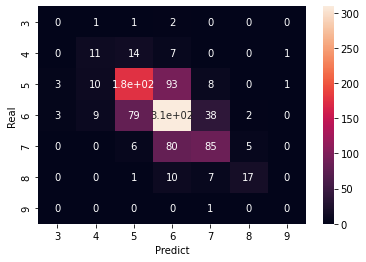

In [85]:
# test 결과 시각화
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_test_pred_list)).rename(columns=idx2class, index=idx2class)

ax = plt.subplot()

sns.heatmap(confusion_matrix_df, annot=True)

ax.set_xlabel('Predict')
ax.set_ylabel('Real')

In [86]:
# test 정확도 계산
correct_pred = (y_test == torch.tensor(y_test_pred_list))

accuracy = correct_pred.sum() / len(correct_pred)

accuracy *= 100.0

print('Test accuracy: ', accuracy)

Test accuracy:  tensor(61.0204)
